In [2]:
import pandas as pd
import numpy as np
import json

from concurrent.futures import ThreadPoolExecutor
from urllib.request import urlopen
from urllib.error import URLError
from tqdm.notebook import tqdm
import datetime
from stockstats import wrap
import warnings
import talib
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [3]:
import torch
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import TiDEModel
from pytorch_lightning.callbacks import Callback, EarlyStopping
from darts.metrics import mape, smape, mae

import warnings
warnings.filterwarnings("ignore")

The `LightGBM` module could not be imported. To enable LightGBM support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `Prophet` module could not be imported. To enable Prophet support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md
The `CatBoost` module could not be imported. To enable CatBoost support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


In [4]:
def get_json_parsed_data(url):
    """Return json object from https://financialmodelingprep.com/ url"""
    return json.loads(urlopen(url).read().decode('utf-8'))

In [5]:
def load_stocks_list(exchange):
  traded_stocks_url = 'https://financialmodelingprep.com/api/v3/available-traded/list?apikey=1401249d9cdf8f975028aa69f2ef15c7'
  stocks = pd.DataFrame(get_json_parsed_data(traded_stocks_url))
  stocks = stocks[(stocks.exchangeShortName == exchange) & (stocks.type == 'stock')].symbol.tolist()
  return stocks

In [6]:
def create_indicators_matrix(exchange, indicators, number_of_treads):
    """Loading close/high/low/volume for specified exchange from provider and
  convert them into indicators matrix using stockstats"""
    traded_stocks__url = 'https://financialmodelingprep.com/api/v3/available-traded/list?apikey=1401249d9cdf8f975028aa69f2ef15c7'
    end = datetime.date.today()
    start = end - datetime.timedelta(days=365 * 2)
    period = 250

    def load_close_prices_and_volumes(stock):
        try:
            price_url = ('https://financialmodelingprep.com/api/v4/historical-price-adjusted'
                         f'/{stock}/1/day/{start}/{end}?apikey=1401249d9cdf8f975028aa69f2ef15c7')
            data = pd.DataFrame(get_json_parsed_data(price_url)['results'])
            close, open, high, low, volume = data[['c']], data[['o']], data[['h']], data[['l']], data[['v']]
            close.fillna(method='ffill', inplace=True)
            high.fillna(method='ffill', inplace=True)
            low.fillna(method='ffill', inplace=True)
            volume.fillna(method='ffill', inplace=True)
            if len(close) >= period and volume['v'][0] >= 20000:
                close = np.flip(close['c'].values[:period])
                open = np.flip(open['o'].values[:period])
                high = np.flip(high['h'].values[:period])
                low = np.flip(low['l'].values[:period])
                volume = np.flip(volume['v'].values[:period])
                return [stock, exchange, {'close': close, 'open': open, 'high': high, 'low': low, 'volume': volume}]
        except (KeyError, IndexError, TypeError, URLError) as error:
            return None
        return None

    matrix_of_indicators = list()
    stocks = pd.DataFrame(get_json_parsed_data(traded_stocks__url))
    stocks = stocks[(stocks.exchangeShortName == exchange) & (stocks.type == 'stock')].symbol.tolist()[:1000]
    print(f'Number of stocks at {exchange}:', len(stocks))
    print('Loading Data ...')
    with ThreadPoolExecutor(max_workers=number_of_treads) as executor:
        for data in executor.map(load_close_prices_and_volumes, stocks):
            try:
                if data:
                    scaler_c = Scaler()
                    matrix_of_indicators.append([data[0], data[1], wrap(pd.DataFrame(data[2]))[indicators],
                                                 scaler_c.fit_transform(
                                                     TimeSeries.from_values(data[2]['close'][:250]))])
            except:
                continue
        print('Loading ended.')
    return matrix_of_indicators

In [7]:
INDICATORS = ['close', 'open', 'high', 'low', 'volume', 'rsi', 'stochrsi', 'close_50_sma', 'close_200_sma', 'boll_ub', 'boll_lb',
       'macd', 'macds', 'wr', 'dx', 'pdi', 'ndi', 'ao']

In [8]:
nasdaq = create_indicators_matrix('NASDAQ', INDICATORS, 10)
#nyse = create_indicators_matrix('NYSE', INDICATORS, 10)
#lse = create_indicators_matrix('LSE', INDICATORS, 10)

matrix = [*nasdaq]#, *nyse, *lse]

Number of stocks at NASDAQ: 1000
Loading Data ...
Loading ended.


In [9]:
matrix[0]

['CSWC',
 'NASDAQ',
       close   open     high      low  volume         rsi    stochrsi  \
 0    18.210  18.50  18.5650  18.1200  314824         NaN         NaN   
 1    18.280  18.21  18.5200  18.1800  143365  100.000000         NaN   
 2    17.910  18.11  18.1400  17.6000  485520   14.942529    0.000000   
 3    18.230  17.90  18.2790  17.8000  289083   52.540701   44.203256   
 4    17.930  18.21  18.2400  17.7700  193041   36.328094   25.142489   
 ..      ...    ...      ...      ...     ...         ...         ...   
 245  21.870  22.14  22.1995  21.8700  172625   53.563219   37.922204   
 246  21.970  21.90  22.0400  21.9000  208824   55.514096   54.257593   
 247  22.075  22.00  22.1500  21.9669  195513   57.531570   71.150622   
 248  22.340  22.23  22.4099  22.1500  289391   62.191852  100.000000   
 249  22.400  22.47  22.4900  22.2700  769814   63.177118  100.000000   
 
      close_50_sma  close_200_sma    boll_ub    boll_lb      macd     macds  \
 0       18.210000     

In [10]:
labelled_matrix = pd.DataFrame()
labelled_matrix['stock'] = [stock[0] for stock in matrix]
labelled_matrix['exchange'] = [stock[1] for stock in matrix]

In [11]:
matrix[0][2]

,close,open,high,low,volume,rsi,stochrsi,close_50_sma,close_200_sma,boll_ub,boll_lb,macd,macds,wr,dx,pdi,ndi,ao
0,18.210,18.50,18.5650,18.1200,314824,NaN,NaN,18.210000,18.210000,NaN,NaN,0.000000,0.000000,-79.775281,NaN,0.000000,-0.000000,0.000000
1,18.280,18.21,18.5200,18.1800,143365,100.000000,NaN,18.245000,18.245000,18.343995,18.146005,0.001571,0.000873,-64.044944,NaN,0.000000,-0.000000,0.000000
2,17.910,18.11,18.1400,17.6000,485520,14.942529,0.000000,18.133333,18.133333,18.526441,17.740226,-0.009473,-0.003367,-67.875648,100.000000,0.000000,42.046863,0.000000
3,18.230,17.90,18.2790,17.8000,289083,52.540701,44.203256,18.157500,18.157500,18.492711,17.822289,-0.002710,-0.003144,-34.715026,58.971115,7.898249,30.602671,0.000000
4,17.930,18.21,18.2400,17.7700,193041,36.328094,25.142489,18.112000,18.112000,18.466514,17.757486,-0.010915,-0.005456,-65.803109,60.838403,6.134055,25.192835,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,21.870,22.14,22.1995,21.8700,172625,53.563219,37.922204,21.225600,18.993125,22.505973,21.393027,0.225803,0.264706,-48.668503,10.256735,20.814500,16.941924,0.474519
246,21.970,21.90,22.0400,21.9000,208824,55.514096,54.257593,21.279100,19.011725,22.421759,21.426241,0.210346,0.253834,-39.485767,10.256735,20.100330,16.360626,0.404366
247,22.075,22.00,22.1500,21.9669,195513,57.531570,71.150622,21.327000,19.031950,22.377273,21.445227,0.204215,0.243910,-29.843893,15.779469,21.630401,15.734429,0.347308
248,22.340,22.23,22.4099,22.1500,289391,62.191852,100.000000,21.378400,19.053950,22.429555,21.424945,0.218224,0.238773,-6.360906,27.181727,25.554580,14.631350,0.319623


In [12]:
rsi = list()
for stock in range(len(matrix)):
    if matrix[stock][2]['rsi'].values.tolist()[-1] > 69:
        rsi.append(1)
    elif matrix[stock][2]['rsi'].values.tolist()[-1] < 31:
        rsi.append(2)
    else:
        rsi.append(0)
labelled_matrix['rsi'] = rsi
labelled_matrix['rsi_value'] = [matrix[stock][2]['rsi'].values.tolist()[-1] for stock in range(len(matrix))]

In [13]:
bollinger = list()
for stock in range(len(matrix)):
    # sell if close is near to cross upper bollinger bound
    if matrix[stock][2]['boll_ub'].values.tolist()[-2] > matrix[stock][2]['close'].values.tolist()[-2] and matrix[stock][2]['close'].values.tolist()[-1] >= matrix[stock][2]['boll_ub'].values.tolist()[-1] * 0.999:
        bollinger.append(1)
    # buy if close is near to cross lower bollinger bound
    elif matrix[stock][2]['boll_lb'].values.tolist()[-2] < matrix[stock][2]['close'].values.tolist()[-2] and matrix[stock][2]['close'].values.tolist()[-1] <= matrix[stock][2]['boll_lb'].values.tolist()[-1] * 1.001:
        bollinger.append(2)
    else:
        bollinger.append(0)
labelled_matrix['bollinger'] = bollinger
labelled_matrix['boll_ub_value'] = [matrix[stock][2]['boll_ub'].values.tolist()[-1] for stock in range(len(matrix))]
labelled_matrix['boll_lb_value'] = [matrix[stock][2]['boll_lb'].values.tolist()[-1] for stock in range(len(matrix))]

In [14]:
macd = list()
for stock in range(len(matrix)):
    if 0 > matrix[stock][2]['macd'].values.tolist()[-1] >= matrix[stock][2]['macds'].values.tolist()[-1] * 0.999 and matrix[stock][2]['macd'].values.tolist()[-2] < matrix[stock][2]['macds'].values.tolist()[-2]:
        macd.append(1)
    elif 0 < matrix[stock][2]['macd'].values.tolist()[-1] <= matrix[stock][2]['macds'].values.tolist()[-1] * 1.001 and matrix[stock][2]['macd'].values.tolist()[-2] > matrix[stock][2]['macds'].values.tolist()[-2]:
        macd.append(2)
    else:
        macd.append(0)
labelled_matrix['macd'] = macd
labelled_matrix['macd_value'] = [matrix[stock][2]['macd'].values.tolist()[-1] for stock in range(len(matrix))]

In [15]:
stochrsi = list()
for stock in range(len(matrix)):
    if matrix[stock][2]['stochrsi'].values.tolist()[-1] > 80:
        stochrsi.append(1)
    elif matrix[stock][2]['stochrsi'].values.tolist()[-1] < 20:
        stochrsi.append(2)
    else:
        stochrsi.append(0)
labelled_matrix['stochrsi'] = stochrsi
labelled_matrix['stochrsi_value'] = [matrix[stock][2]['stochrsi'].values.tolist()[-1] for stock in range(len(matrix))]

In [16]:
williams = list()
for stock in range(len(matrix)):
    if -20 <= matrix[stock][2]['wr'].values.tolist()[-1] <= 0:
        williams.append(1)
    elif -100 <= matrix[stock][2]['wr'].values.tolist()[-1] <= -80:
        williams.append(2)
    else:
        williams.append(0)
labelled_matrix['williams'] = williams
labelled_matrix['williams_value'] = [matrix[stock][2]['wr'].values.tolist()[-1] for stock in range(len(matrix))]

In [17]:
sma = list()
for stock in range(len(matrix)):
    if matrix[stock][2]['close_50_sma'].values.tolist()[-1] <= matrix[stock][2]['close_200_sma'].values.tolist()[-1] * 1.001 and matrix[stock][2]['close_50_sma'].values.tolist()[-2] > matrix[stock][2]['close_200_sma'].values.tolist()[-2]:
        sma.append(1)
    elif matrix[stock][2]['close_50_sma'].values.tolist()[-1] >= matrix[stock][2]['close_200_sma'].values.tolist()[-1] * 0.999 and matrix[stock][2]['close_50_sma'].values.tolist()[-2] < matrix[stock][2]['close_200_sma'].values.tolist()[-2]:
        sma.append(2)
    else:
        sma.append(0)
labelled_matrix['sma'] = sma
labelled_matrix['sma_50_value'] = [matrix[stock][2]['close_50_sma'].values.tolist()[-1] for stock in range(len(matrix))]
labelled_matrix['sma_200_value'] = [matrix[stock][2]['close_200_sma'].values.tolist()[-1] for stock in range(len(matrix))]

In [18]:
ao = list()
for stock in range(len(matrix)):
    if matrix[stock][2]['ao'].values.tolist()[-3] < 0 and matrix[stock][2]['ao'].values.tolist()[-2] < 0 and matrix[stock][2]['ao'].values.tolist()[-1] >= 0:
        ao.append(1)
    elif matrix[stock][2]['ao'].values.tolist()[-3] > 0 and matrix[stock][2]['ao'].values.tolist()[-2] > 0 and matrix[stock][2]['ao'].values.tolist()[-1] <= 0:
        ao.append(2)
    else:
        ao.append(0)
labelled_matrix['ao'] = ao
labelled_matrix['ao_value'] = [matrix[stock][2]['ao'].values.tolist()[-1] for stock in range(len(matrix))]

In [ ]:
adx = list()
for stock in range(len(matrix)):
    if matrix[stock][2]['dx'].values.tolist()[-1] >= 25 and matrix[stock][2]['pdi'].values.tolist()[-1] < \
            matrix[stock][2]['ndi'].values.tolist()[-1] * 1.001 and matrix[stock][2]['ndi'].values.tolist()[-2] < \
            matrix[stock][2]['pdi'].values.tolist()[-2]:
        adx.append(1)
    elif matrix[stock][2]['dx'].values.tolist()[-1] >= 25 and matrix[stock][2]['pdi'].values.tolist()[-1] > \
            matrix[stock][2]['ndi'].values.tolist()[-1] * 0.999 and matrix[stock][2]['ndi'].values.tolist()[-2] > \
            matrix[stock][2]['pdi'].values.tolist()[-2]:
        adx.append(2)
    else:
        adx.append(0)
labelled_matrix['adx'] = adx

labelled_matrix['close'] = [matrix[stock][2]['close'].values.tolist()[-1] for stock in range(len(matrix))]
labelled_matrix['open'] = [matrix[stock][2]['open'].values.tolist()[-1] for stock in range(len(matrix))]
labelled_matrix['high'] = [matrix[stock][2]['high'].values.tolist()[-1] for stock in range(len(matrix))]
labelled_matrix['low'] = [matrix[stock][2]['low'].values.tolist()[-1] for stock in range(len(matrix))]
labelled_matrix['volume'] = [matrix[stock][2]['volume'].values.tolist()[-1] for stock in range(len(matrix))]

scaler_c = Scaler()
model_loaded = TiDEModel.load("/home/liza/PycharmProjects/ml_stocks_classifier/model_TiDEModel_ema.pt",
                              map_location="cpu")
model_loaded.to_cpu()

labelled_matrix['close_scaled'] = [
    scaler_c.fit_transform(TimeSeries.from_values(matrix[stock][2]['close'].values[:250])) for stock in
    range(len(matrix))]

goes_up = 1
goes_down = -1
neutral = 0

buy_icon = '1'
sell_icon = '-1'
neutral = '0'

predictions = []
for stock in range(len(labelled_matrix)):
    prediction = model_loaded.predict(n=5, series=labelled_matrix['close_scaled'][stock])
    prices = [np.array(labelled_matrix['close_scaled'].values[0].data_array()).flatten()[-1],
                  *np.array(prediction.data_array()).flatten()]
    moves = list()
    rises = 0
    for day in range(len(prices) - 1):
        if prices[day + 1] < prices[day]:
            moves.append(sell_icon)
        elif prices[day + 1] > prices[day]:
            moves.append(buy_icon)
            rises += 1
        else:
            moves.append(neutral)
    predictions.append([*prices[0:], rises])

for column in range(5):
    labelled_matrix['prediction_' + str(column)] = [predictions[stock][column] for stock in range(len(predictions))]
labelled_matrix['rises'] = [predictions[stock][5] for stock in range(len(predictions))]

In [34]:
labelled_matrix.columns

Index(['stock', 'exchange', 'rsi', 'rsi_value', 'bollinger', 'boll_ub_value',
       'boll_lb_value', 'macd', 'macd_value', 'stochrsi', 'stochrsi_value',
       'williams', 'williams_value', 'sma', 'sma_50_value', 'sma_200_value',
       'ao', 'ao_value', 'adx', 'close', 'open', 'high', 'low', 'volume',
       'close_scaled', 'prediction_0', 'prediction_1', 'prediction_2',
       'prediction_3', 'prediction_4', 'rises'],
      dtype='object')

In [ ]:
# 0 - hold 1 - sell 2 -buy

In [35]:
labelled_matrix.head()

,stock,exchange,rsi,rsi_value,bollinger,boll_ub_value,boll_lb_value,macd,macd_value,stochrsi,...,high,low,volume,close_scaled,prediction_0,prediction_1,prediction_2,prediction_3,prediction_4,rises
0,CSWC,NASDAQ,0,63.177118,0,22.457631,21.409869,0,0.231500,1,...,22.4900,22.2700,769814,"(((<TimeSeries (DataArray) (time: 1, component...",0.980969,1.011580,1.009717,1.002716,1.019403,0.996403
1,IDEX,NASDAQ,2,22.222979,0,7.501132,0.657868,1,-1.649982,0,...,2.3400,2.1400,662906,"(((<TimeSeries (DataArray) (time: 1, component...",0.980969,0.006592,0.015466,0.018916,0.024137,0.029947
2,JAGX,NASDAQ,2,27.278779,0,0.533106,0.289294,0,-0.054916,0,...,0.3449,0.3229,447912,"(((<TimeSeries (DataArray) (time: 1, component...",0.980969,0.002087,0.004532,0.004400,0.006037,0.006540
3,RVNC,NASDAQ,0,31.573838,0,19.638965,15.543535,0,-1.378126,0,...,16.2300,15.1300,2815635,"(((<TimeSeries (DataArray) (time: 1, component...",0.980969,0.053601,0.086293,0.085944,0.118764,0.120911
4,WULF,NASDAQ,0,37.930920,0,2.322309,1.630191,0,-0.197251,2,...,2.0500,1.7600,7253079,"(((<TimeSeries (DataArray) (time: 1, component...",0.980969,0.363480,0.418898,0.397131,0.443174,0.442840


In [49]:
y = labelled_matrix[labelled_matrix.stock == 'GOOGL'][['prediction_0', 'prediction_1', 'prediction_2', 'prediction_3', 'prediction_4']].values.tolist()[0]

In [50]:
y

[0.9809688581314875,
 0.9618835753126294,
 0.9464711325436085,
 0.9485618957206816,
 0.9370364128639047]

In [44]:
len(list(np.array(labelled_matrix['close_scaled'].values[0].data_array()).flatten()))

250

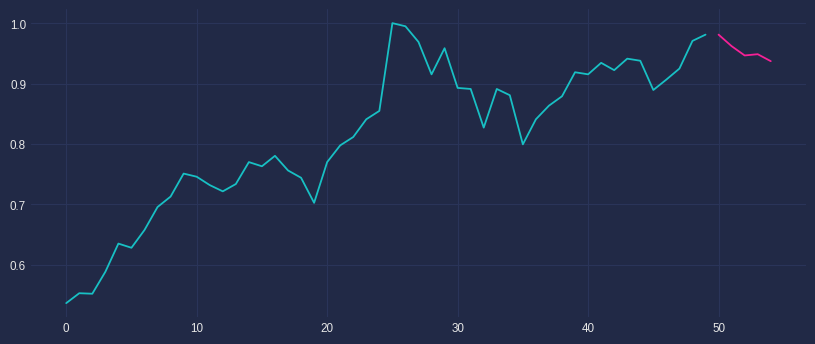

In [61]:
plt.rcParams["figure.figsize"] = (10, 4)
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
plt.plot([i for i in range(50)], list(np.array(labelled_matrix['close_scaled'].values[0].data_array()).flatten()[-50:]))
plt.plot([i + 50 for i in range(5)], y)
plt.savefig('test2png.png', dpi=100)

In [55]:
plt.figure([i for i in range(50)], y)

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'list'

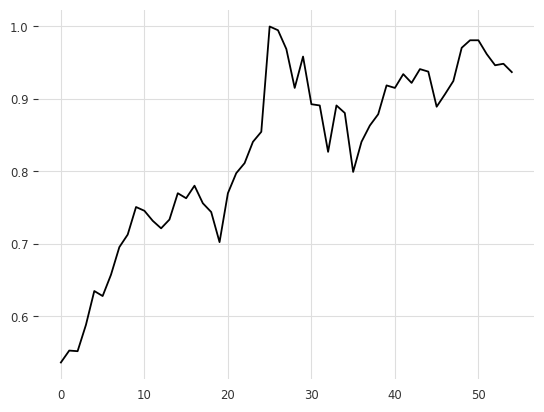

In [45]:
plt.plot([i for i in range(55)], [*list(np.array(labelled_matrix['close_scaled'].values[0].data_array()).flatten()[-50:]), *y])

In [30]:
import yfinance as yf
import matplotlib.pyplot as plt
price_history = yf.Ticker('TSLA').history(period='1y', interval='1d', actions=False)

In [104]:
price_history

,Open,High,Low,Close,Volume
Date,,,,,
2022-09-09 00:00:00-04:00,291.670013,299.850006,291.250000,299.679993,54338100
2022-09-12 00:00:00-04:00,300.720001,305.489990,300.399994,304.420013,48674600
2022-09-13 00:00:00-04:00,292.899994,297.399994,290.399994,292.130005,68229600
2022-09-14 00:00:00-04:00,292.239990,306.000000,291.640015,302.609985,72628700
2022-09-15 00:00:00-04:00,301.829987,309.119995,300.720001,303.750000,64795500
...,...,...,...,...,...
2023-09-01 00:00:00-04:00,257.260010,259.079987,242.009995,245.009995,132272500
2023-09-05 00:00:00-04:00,245.000000,258.000000,244.860001,256.489990,129469600
2023-09-06 00:00:00-04:00,255.139999,255.389999,245.059998,251.919998,116959800


In [34]:
import requests

api_key = '1401249d9cdf8f975028aa69f2ef15c7'
hist_json = requests.get(f'https://financialmodelingprep.com/api/v3/historical-price-full/AAPL?apikey={api_key}').json()

hist_df = pd.DataFrame(hist_json['historical']).drop('label', axis = 1)
hist_df = hist_df.iloc[::-1].reset_index().drop(['index','adjClose'], axis = 1)
hist_df.date = pd.to_datetime(hist_df.date)
hist_df = hist_df.iloc[:,:6].iloc[-365:]
hist_df.columns = ['time', 'open', 'high', 'low', 'close', 'volume']

hist_df.tail()

,time,open,high,low,close,volume
1251,2023-09-01,189.485,189.920,188.28,189.46,45393903
1252,2023-09-05,188.280,189.980,187.61,189.70,45280027
1253,2023-09-06,188.400,188.850,181.47,182.91,81753366
1254,2023-09-07,175.180,178.210,173.54,177.56,112416703
1255,2023-09-08,178.350,180.239,177.79,178.18,65300297


In [37]:
hist_df[:10]

,time,open,high,low,close,volume
891,2022-03-28,172.17,175.73,172.00,175.60,90371900
892,2022-03-29,176.69,179.01,176.34,178.96,100589400
893,2022-03-30,178.55,179.61,176.70,177.77,92633200
894,2022-03-31,177.84,178.03,174.40,174.61,103049300
895,2022-04-01,174.03,174.88,171.94,174.31,78751300
896,2022-04-04,174.57,178.49,174.44,178.44,76468400
897,2022-04-05,177.50,178.30,174.42,175.06,73401800
898,2022-04-06,172.36,173.63,170.13,171.83,89058800
899,2022-04-07,171.16,173.36,169.85,172.14,77594700
900,2022-04-08,171.78,171.78,169.20,170.09,76575500


In [22]:
import mplfinance as mpf
# convert unix timestamp (in milliseconds) to datetime
hist_df["Datetime"] = pd.to_datetime(hist_df["time"], unit="d")

# set datetime as the index
hist_df.set_index("Datetime", inplace=True)

NameError: name 'hist_df' is not defined

In [43]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

In [47]:
hist_df[-50:]

,time,open,high,low,close,volume
Datetime,,,,,,
2023-06-29,2023-06-29,189.080,190.0700,188.940,189.59,46347300
2023-06-30,2023-06-30,191.630,194.4800,191.260,193.97,85069600
2023-07-03,2023-07-03,193.780,193.8800,191.760,192.46,31458200
2023-07-05,2023-07-05,191.570,192.9800,190.620,191.33,46920300
2023-07-06,2023-07-06,189.840,192.0200,189.200,191.81,45094300
2023-07-07,2023-07-07,191.410,192.6700,190.240,190.68,46778000
2023-07-10,2023-07-10,189.260,189.9900,187.040,188.61,59922200
2023-07-11,2023-07-11,189.160,189.3000,186.600,188.08,46638100
2023-07-12,2023-07-12,189.680,191.7000,188.470,189.77,60750200


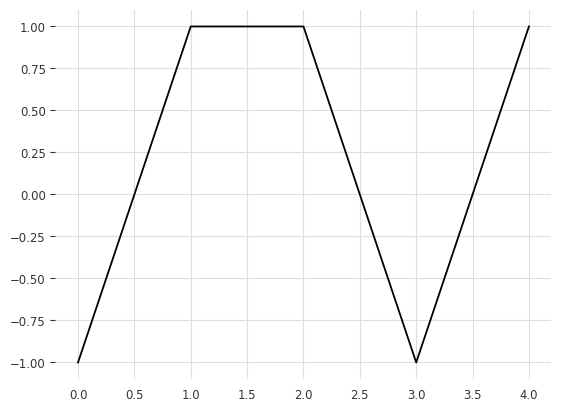

In [26]:
plt.plot(labelled_matrix.iloc[6][['prediction_' + str(column) for column in range(5)]].tolist())

In [21]:
fig, axes = mpf.plot(
    hist_df[-50:],
    type="candle",
    title="BTC/USDT Daily Prices - 2023",
    volume=True,
    returnfig=True,
    style='kenan'
)

NameError: name 'mpf' is not defined